## Imports and functions

In [1]:
from keras_segmentation import predict
from keras_segmentation.models.unet import vgg_unet
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from datetime import datetime
from pathlib import Path
import tensorflow as tf
from keras_segmentation.predict import model_from_checkpoint_path

print('TF version', tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.utils import io

def find_best_model(checkpoints_path, max_epochs):
    
    results = []
    for i in tqdm(range(max_epochs)):
        with io.capture_output() as captured:
            model = model_from_checkpoint_path(checkpoints_path, i+1)
            res = predict.evaluate( model=model, inp_images_dir="data/mars_data_20210923/val/images",
                                          annotations_dir="data/mars_data_20210923/val/annotations",
                                         read_image_type=0);
        results.append(res)

    frequency_weighted_IU = [ r['frequency_weighted_IU'] for r in results ]
    mean_IU = [ r['mean_IU'] for r in results ]
    class_wise_IU = np.array([ r['class_wise_IU'] for r in results ])
    
    fig, ax = plt.subplots(3, 1, figsize=(10,10))
    ax[0].plot(frequency_weighted_IU)
    ax[1].set_title('Freq. IOU')

    ax[1].plot(mean_IU)
    ax[1].set_title('Mean IOU')

    ax[2].plot(class_wise_IU[:, 1:3])
    # ax[2].set_legend([ 'cones', 'craters'])
    ax[2].set_title('Class wise IOU')
    plt.show()
    
    mean_IU_best_epoch = np.argmax(mean_IU) + 1
    print('Mean IU', np.max(mean_IU), mean_IU_best_epoch)
    print('Class wise IU', np.max(class_wise_IU, axis=0)) # , np.argmax(mean_IU) + 1)
    print('Class wise IU best epoch', np.argmax(class_wise_IU, axis=0)+1)
    return mean_IU_best_epoch


def plot_prediction(model):

#     model = model_from_checkpoint_path('logs\\unet_mini_2021-09-27_231224.688994\\checkpoints\\unet_mini', 72)
    #
    inp_img = 'data/mars_data_20210923/test_0.1/images/unnamed_testing_2_patch_011_00720_00480_r0.10.png'
    ann_img = 'data/mars_data_20210923/test_0.1/annotations/unnamed_testing_2_patch_011_00720_00480_r0.10.png'
    pr = predict.predict(model=model,
                    inp=inp_img,
                    out_fname=None,
                    read_image_type=0,
                    # class_names = [ "background",    "cone", "crater" ],
                    # overlay_img=True, show_legends=True
                    )

    import cv2

    inp = cv2.imread(inp_img, 0)
    ann = cv2.imread(ann_img, 1)

    fig, ax = plt.subplots(1, 3, figsize=(20,7))
    ax[0].imshow(inp, cmap='gray')
    ax[0].set_title('Input image')
    ax[1].matshow(ann[:,:,0], vmin=0)
    ax[1].set_title('Target')
    ax[2].matshow(pr, vmin=0)
    ax[2].set_title('Predicted')
    plt.show()

    for i in (0, 1, 2):
        npx = np.sum(pr == i)
        apx = np.sum(ann[:,:,0] == i)
        print('Output %2d: %8d %8.3f%%, annotations %8d %8.3f%%' % (i, npx, 100* npx / pr.size, apx, 100 * apx / ann[:,:,0].size  ))

        
def evaluate(model):
    with io.capture_output() as captured:
     
        val_eval = predict.evaluate( model=model, inp_images_dir="data/mars_data_20210923/val/images",
                                  annotations_dir="data/mars_data_20210923/val/annotations",
                                 read_image_type=0) 
        test1_eval = predict.evaluate( model=model, inp_images_dir="data/mars_data_20210923/test_0.1/images",
                                  annotations_dir="data/mars_data_20210923/test_0.1/annotations",
                                 read_image_type=0)
        test2_eval = predict.evaluate( model=model, inp_images_dir="data/mars_data_20210923/test_0.05/images",
                                  annotations_dir="data/mars_data_20210923/test_0.05/annotations",
                                 read_image_type=0) 
    print('\ndata      | mean IOU | cone IOU | crater IOU ')
    print('Val       | %8.5f | %8.5f | %8.5f' % (val_eval['mean_IU'], val_eval['class_wise_IU'][1], val_eval['class_wise_IU'][2]) )
    print('Test 0.1  | %8.5f | %8.5f | %8.5f' % (test1_eval['mean_IU'], test1_eval['class_wise_IU'][1], test1_eval['class_wise_IU'][2]) )
    print('Test 0.05 | %8.5f | %8.5f | %8.5f' % (test2_eval['mean_IU'], test2_eval['class_wise_IU'][1], test2_eval['class_wise_IU'][2]) )
    
    

TF version 2.3.4
Num GPUs Available:  3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


## unet_mini 30 epochs

512 steps per epoch, 30 epochs (15K steps)  



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:12<00:00,  2.41s/it]


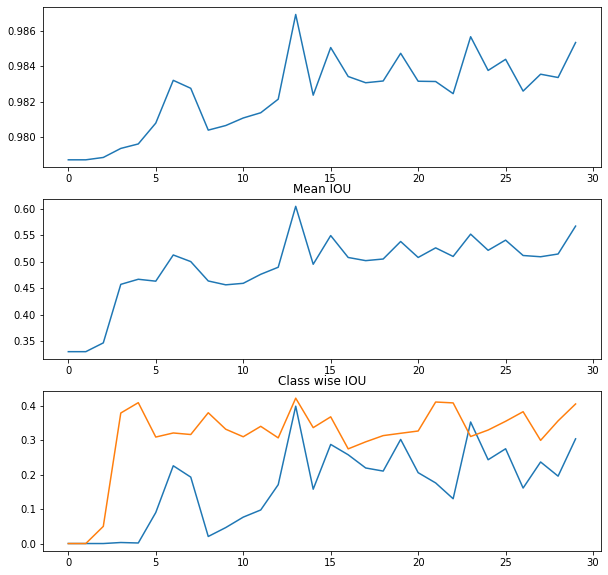

Mean IU 0.60527702382909 14
Class wise IU [0.99327702 0.39963697 0.42291708]
Class wise IU best epoch [14 14 14]
Best epoch:  14


In [43]:
model_path = 'unet_mini_2021-09-27_003743.848447'
model_name = 'unet_mini'
max_epochs = 30
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name

best_epoch = find_best_model(checkpoints_path, max_epochs);
print('Best epoch: ', best_epoch)

loaded weights  logs\unet_mini_2021-09-27_003743.848447\checkpoints\unet_mini.00014


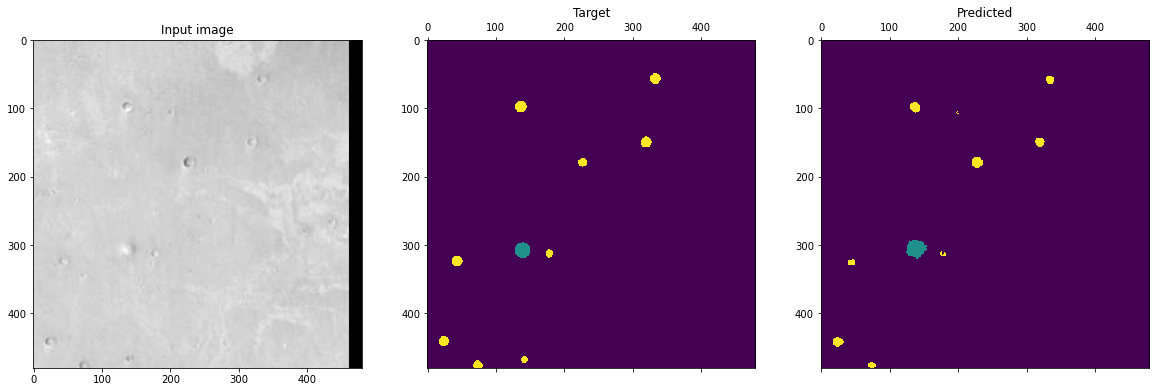

Output  0:   228751   99.284%, annotations   228588   99.214%
Output  1:      599    0.260%, annotations      414    0.180%
Output  2:     1050    0.456%, annotations     1398    0.607%

Model:  unet_mini
Path:   logs\unet_mini_2021-09-27_003743.848447\checkpoints\unet_mini
Epoch:  14

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.60528 |  0.39964 |  0.42292
Test 0.1  |  0.56384 |  0.23093 |  0.46632
Test 0.05 |  0.46554 |  0.16174 |  0.24009


In [44]:
epoch = 14
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

## unet_mini 100 epochs (break after 70 epochs)

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [02:47<00:00,  2.33s/it]


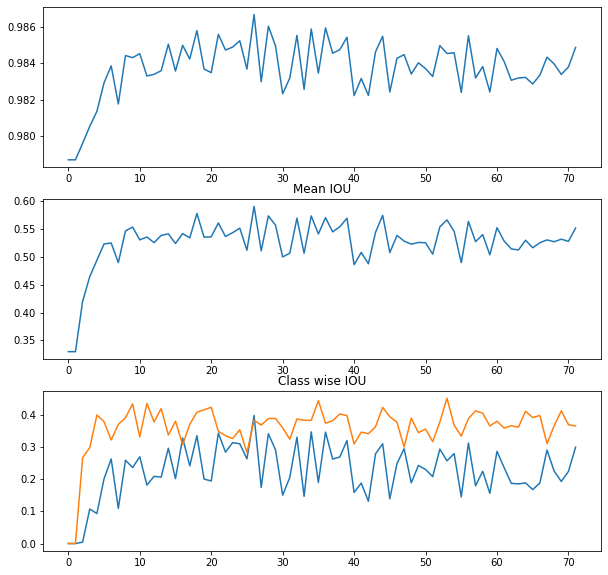

Mean IU 0.5908931166015244 27
Class wise IU [0.99307447 0.39719997 0.45073625]
Class wise IU best epoch [27 27 54]
Best epoch:  27


In [2]:
model_path = 'unet_mini_2021-09-27_231224.688994'
model_name = 'unet_mini'
max_epochs = 72
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name

best_epoch = find_best_model(checkpoints_path, max_epochs);
print('Best epoch: ', best_epoch)

loaded weights  logs\unet_mini_2021-09-27_231224.688994\checkpoints\unet_mini.00027


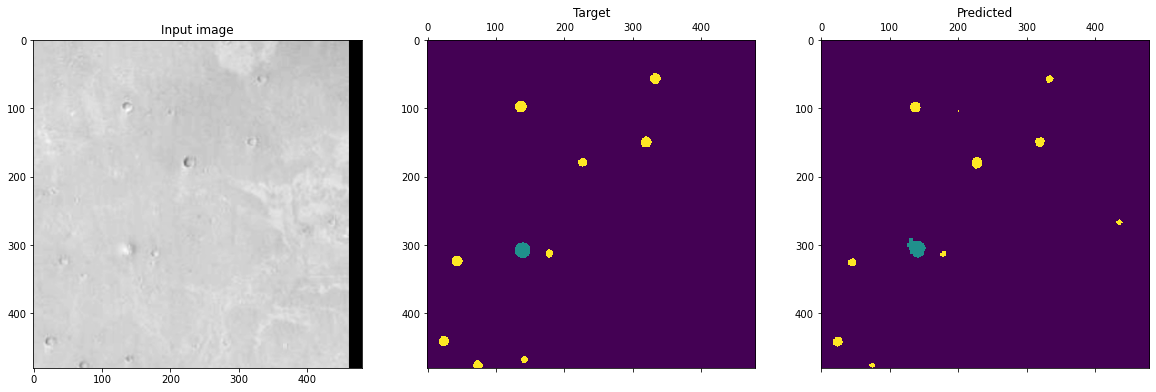

Output  0:   228799   99.305%, annotations   228588   99.214%
Output  1:      536    0.233%, annotations      414    0.180%
Output  2:     1065    0.462%, annotations     1398    0.607%

Model:  unet_mini
Path:   logs\unet_mini_2021-09-27_231224.688994\checkpoints\unet_mini
Epoch:  27

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.59089 |  0.39720 |  0.38240
Test 0.1  |  0.55890 |  0.21729 |  0.46562
Test 0.05 |  0.46761 |  0.13615 |  0.27248


In [3]:
epoch = best_epoch
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

loaded weights  logs\unet_mini_2021-09-27_231224.688994\checkpoints\unet_mini.00027


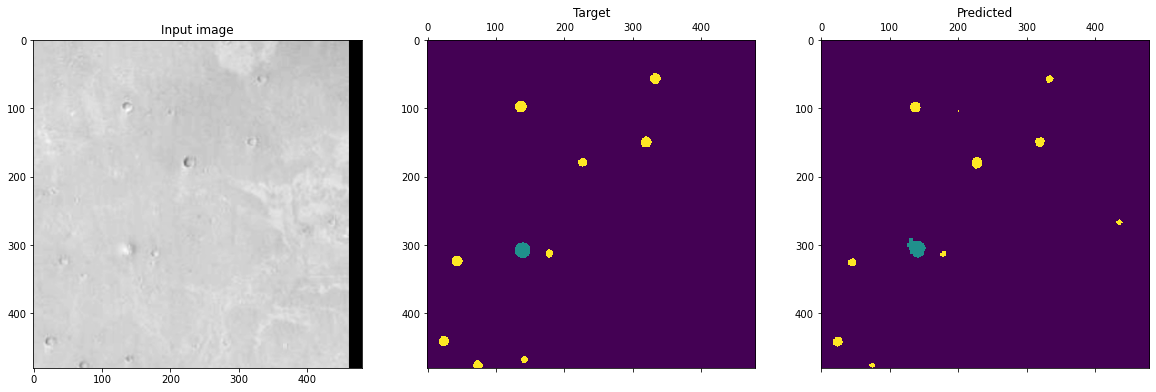

Output  0:   228799   99.305%, annotations   228588   99.214%
Output  1:      536    0.233%, annotations      414    0.180%
Output  2:     1065    0.462%, annotations     1398    0.607%

Model:  unet_mini
Path:   logs\unet_mini_2021-09-27_231224.688994\checkpoints\unet_mini
Epoch:  27

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.59089 |  0.39720 |  0.38240
Test 0.1  |  0.55890 |  0.21729 |  0.46562
Test 0.05 |  0.46761 |  0.13615 |  0.27248


In [4]:
epoch = 27
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

## unet 50 epochs (break after 36 epochs)

```
# callbacks = None
model.train(
    train_images =  "data/mars_data_20210923/train/images/",
    train_annotations = "data/mars_data_20210923/train/annotations/",
    batch_size = 20,
    steps_per_epoch = 512,
    checkpoints_path =str( checkpoint_path / model.model_name ) ,
    epochs=50,
    val_images = "data/mars_data_20210923/val/images/",
    val_annotations = "data/mars_data_20210923/val/annotations",
    validate=True,
    val_steps_per_epoch=512,
    callbacks=callbacks,
    read_image_type=0,
    do_augment=True,
    ignore_zero_class=False
)
```

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [01:13<00:00,  2.10s/it]


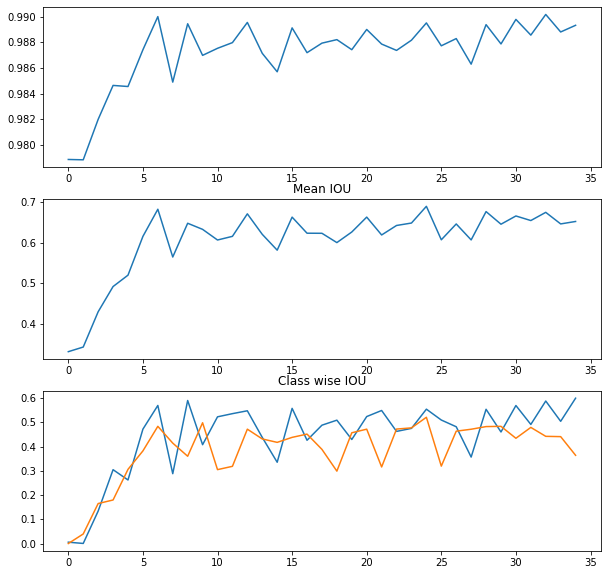

Mean IU 0.6896743887640722 25
Class wise IU [0.99474491 0.59939172 0.52065322]
Class wise IU best epoch [33 35 25]
Best epoch:  25


In [2]:
model_path = 'unet_2021-09-29_005610.184117'
model_name = 'unet'
max_epochs = 35
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name

best_epoch = find_best_model(checkpoints_path, max_epochs);
print('Best epoch: ', best_epoch)

loaded weights  logs\unet_2021-09-29_005610.184117\checkpoints\unet.00025


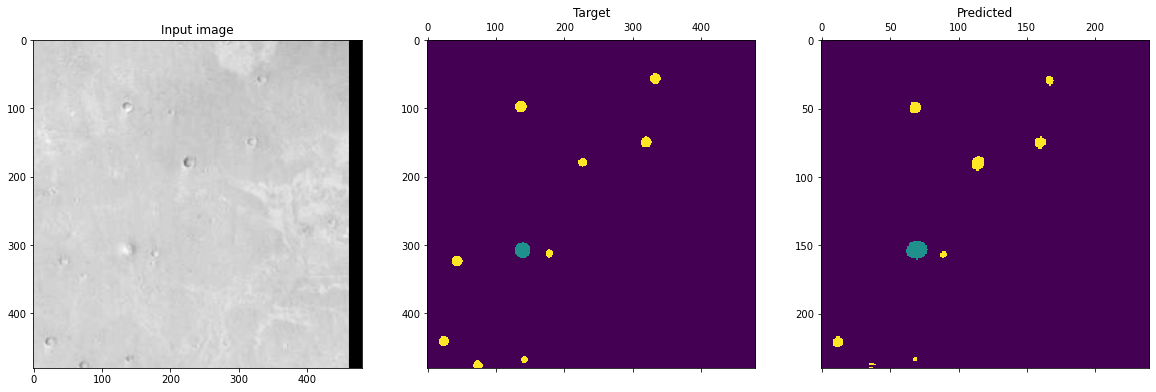

Output  0:    57136   99.194%, annotations   228588   99.214%
Output  1:      163    0.283%, annotations      414    0.180%
Output  2:      301    0.523%, annotations     1398    0.607%

Model:  unet
Path:   logs\unet_2021-09-29_005610.184117\checkpoints\unet
Epoch:  25

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.68967 |  0.55409 |  0.52065
Test 0.1  |  0.58019 |  0.19035 |  0.55652
Test 0.05 |  0.51144 |  0.09611 |  0.44275


In [3]:
epoch = best_epoch
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

loaded weights  logs\unet_2021-09-29_005610.184117\checkpoints\unet.00025


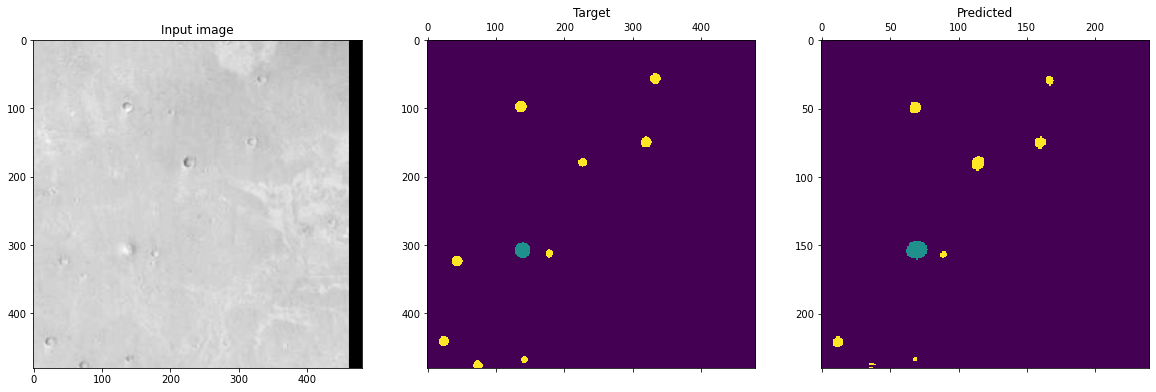

Output  0:    57136   99.194%, annotations   228588   99.214%
Output  1:      163    0.283%, annotations      414    0.180%
Output  2:      301    0.523%, annotations     1398    0.607%

Model:  unet
Path:   logs\unet_2021-09-29_005610.184117\checkpoints\unet
Epoch:  25

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.68967 |  0.55409 |  0.52065
Test 0.1  |  0.58019 |  0.19035 |  0.55652
Test 0.05 |  0.51144 |  0.09611 |  0.44275


In [36]:
epoch = 25
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

## vgg_unet default 50 epochs

```python
model = vgg_unet(n_classes=3, input_height=480, input_width=480, channels=1 )

model.train(
    train_images =  "data/mars_data_20210923/train/images/",
    train_annotations = "data/mars_data_20210923/train/annotations/",
    batch_size = 20,
    steps_per_epoch = 512,
    checkpoints_path =str( checkpoint_path / model.model_name ) ,
    epochs=50,
    val_images = "data/mars_data_20210923/val/images/",
    val_annotations = "data/mars_data_20210923/val/annotations",
    validate=True,
    val_steps_per_epoch=512,
    callbacks=callbacks,
    read_image_type=0,
    do_augment=True,
    ignore_zero_class=False
)
```

Note:
* seems like training should be longer, loss is still edcreasing


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/50 [00:02<02:19,  2.85s/it]

  4%|███▎                                                                               | 2/50 [00:04<01:56,  2.43s/it]

  6%|████▉                                                                              | 3/50 [00:07<01:48,  2.31s/it]

  8%|██████▋                                                                            | 4/50 [00:09<01:43,  2.25s/it]

 10%|████████▎                                                                          | 5/50 [00:11<01:39,  2.22s/it]

 12%|█████████▉                                                                         | 6/50 [00:13<01:36,  2.19s/it]

 14%|███████████▌                                                                       | 7/50 [00:15<01:33,  2.17s/it]

 16%|█████████████▎                                                                     | 8/50 [00:17<01:30,  2.16s/it]

 18%|██████████████▉                                                                    | 9/50 [00:20<01:28,  2.15s/it]

 20%|████████████████▍                                                                 | 10/50 [00:22<01:26,  2.16s/it]

 22%|██████████████████                                                                | 11/50 [00:24<01:24,  2.17s/it]

 24%|███████████████████▋                                                              | 12/50 [00:26<01:22,  2.17s/it]

 26%|█████████████████████▎                                                            | 13/50 [00:29<01:30,  2.45s/it]

 28%|██████████████████████▉                                                           | 14/50 [00:31<01:25,  2.36s/it]

 30%|████████████████████████▌                                                         | 15/50 [00:34<01:21,  2.31s/it]

 32%|██████████████████████████▏                                                       | 16/50 [00:36<01:17,  2.28s/it]

 34%|███████████████████████████▉                                                      | 17/50 [00:38<01:14,  2.26s/it]

 36%|█████████████████████████████▌                                                    | 18/50 [00:40<01:11,  2.24s/it]

 38%|███████████████████████████████▏                                                  | 19/50 [00:42<01:08,  2.22s/it]

 40%|████████████████████████████████▊                                                 | 20/50 [00:44<01:06,  2.21s/it]

 42%|██████████████████████████████████▍                                               | 21/50 [00:47<01:03,  2.20s/it]

 44%|████████████████████████████████████                                              | 22/50 [00:49<01:01,  2.19s/it]

 46%|█████████████████████████████████████▋                                            | 23/50 [00:51<00:59,  2.19s/it]

 48%|███████████████████████████████████████▎                                          | 24/50 [00:53<00:56,  2.17s/it]

 50%|█████████████████████████████████████████                                         | 25/50 [00:55<00:54,  2.17s/it]

 52%|██████████████████████████████████████████▋                                       | 26/50 [00:57<00:52,  2.17s/it]

 54%|████████████████████████████████████████████▎                                     | 27/50 [01:00<00:49,  2.17s/it]

 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:02<00:47,  2.17s/it]

 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:04<00:45,  2.16s/it]

 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:06<00:43,  2.15s/it]

 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:08<00:40,  2.15s/it]

 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:10<00:38,  2.15s/it]

 66%|██████████████████████████████████████████████████████                            | 33/50 [01:12<00:36,  2.14s/it]

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:15<00:34,  2.14s/it]

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:17<00:32,  2.15s/it]

 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:19<00:30,  2.16s/it]

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:21<00:28,  2.16s/it]

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:23<00:26,  2.18s/it]

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:26<00:24,  2.18s/it]

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:28<00:21,  2.17s/it]

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:30<00:19,  2.17s/it]

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:32<00:17,  2.17s/it]

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:34<00:15,  2.18s/it]

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:36<00:13,  2.18s/it]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:39<00:10,  2.17s/it]

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:41<00:08,  2.17s/it]

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:43<00:06,  2.16s/it]

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:45<00:04,  2.16s/it]

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:47<00:02,  2.17s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:50<00:00,  2.22s/it]


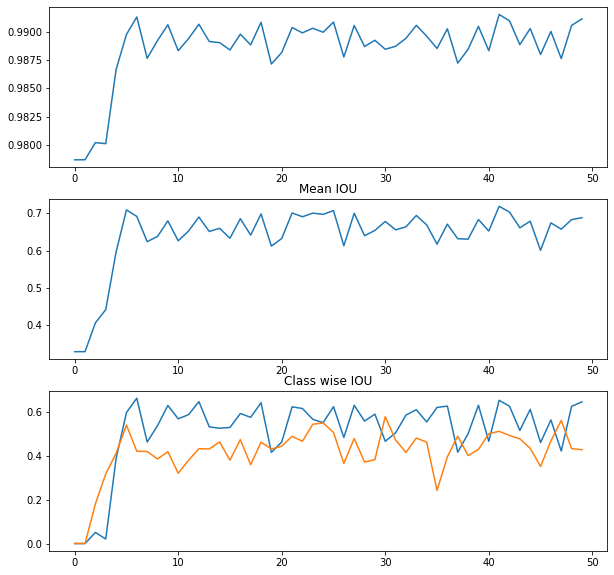

Mean IU 0.7191433677747869 42
Class wise IU [0.99539387 0.6611855  0.57708831]
Class wise IU best epoch [42  7 31]
Best epoch:  42


In [47]:
model_path = 'vgg_unet_2021-09-29_132526.566811'
model_name = 'vgg_unet'
max_epochs = 50
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name

best_epoch = find_best_model(checkpoints_path, max_epochs);
print('Best epoch: ', best_epoch)

loaded weights  logs\vgg_unet_2021-09-29_132526.566811\checkpoints\vgg_unet.00042


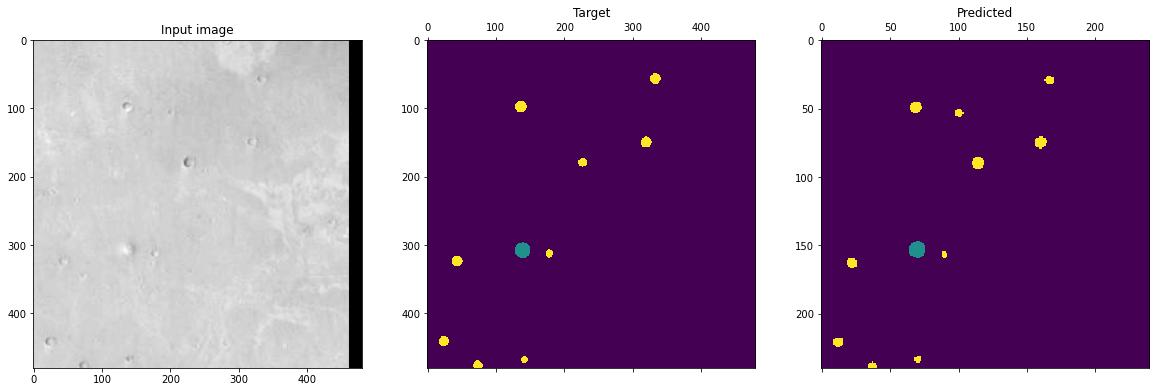

Output  0:    57089   99.113%, annotations   228588   99.214%
Output  1:      121    0.210%, annotations      414    0.180%
Output  2:      390    0.677%, annotations     1398    0.607%

Model:  vgg_unet
Path:   logs\vgg_unet_2021-09-29_132526.566811\checkpoints\vgg_unet
Epoch:  42

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.71914 |  0.65150 |  0.51054
Test 0.1  |  0.56772 |  0.21187 |  0.49759
Test 0.05 |  0.48887 |  0.11065 |  0.36144


In [48]:
epoch = best_epoch
epoch = 42
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

## FCN_8 50 epochs

```python 
model = fcn.fcn_8( n_classes=3, input_height=480, input_width=480, channels=1 )

model.train(
    train_images =  "data/mars_data_20210923/train/images/",
    train_annotations = "data/mars_data_20210923/train/annotations/",
    batch_size = 20,
    steps_per_epoch = 512,
    checkpoints_path =str( checkpoint_path / model.model_name ) ,
    epochs=50,
    val_images = "data/mars_data_20210923/val/images/",
    val_annotations = "data/mars_data_20210923/val/annotations",
    validate=True,
    val_steps_per_epoch=512,
    callbacks=callbacks,
    read_image_type=0,
    do_augment=True,
    ignore_zero_class=False
)
```

## FCN_8 50 epochs 

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:56<00:00,  3.54s/it]


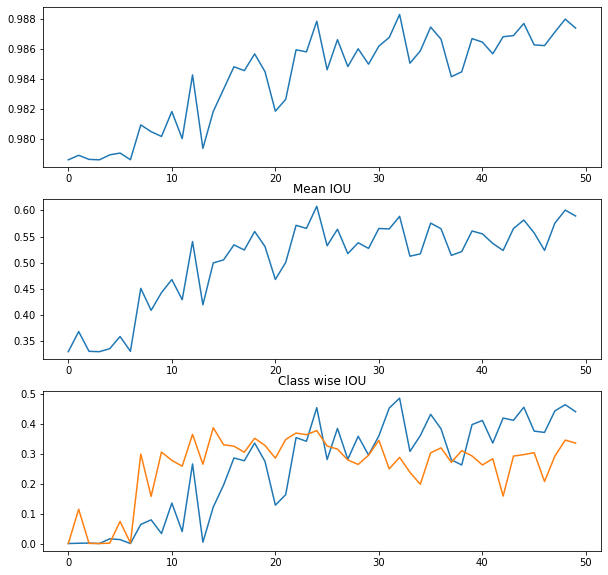

Mean IU 0.6078982680658952 25
Class wise IU [0.99402967 0.48483436 0.3862608 ]
Class wise IU best epoch [33 33 15]
Best epoch:  25


In [49]:
model_path = 'fcn_8_2021-09-30_131016.298459'
model_name = 'fcn_8'
max_epochs = 50
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name

best_epoch = find_best_model(checkpoints_path, max_epochs);
print('Best epoch: ', best_epoch)

loaded weights  logs\fcn_8_2021-09-30_131016.298459\checkpoints\fcn_8.00033


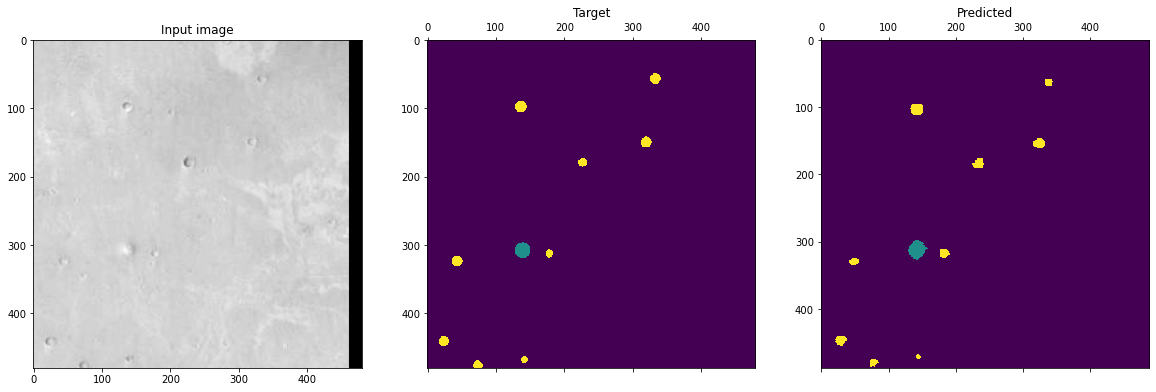

Output  0:   236159   99.166%, annotations   228588   99.214%
Output  1:      566    0.238%, annotations      414    0.180%
Output  2:     1419    0.596%, annotations     1398    0.607%

Model:  fcn_8
Path:   logs\fcn_8_2021-09-30_131016.298459\checkpoints\fcn_8
Epoch:  33

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.58874 |  0.48483 |  0.28736
Test 0.1  |  0.52328 |  0.19243 |  0.38421
Test 0.05 |  0.42224 |  0.06753 |  0.20466


In [55]:
# epoch = best_epoch
epoch = 33
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

## FCN 32 default 50 epochs

Note: need more epochs, training is to short


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:53<00:00,  3.48s/it]


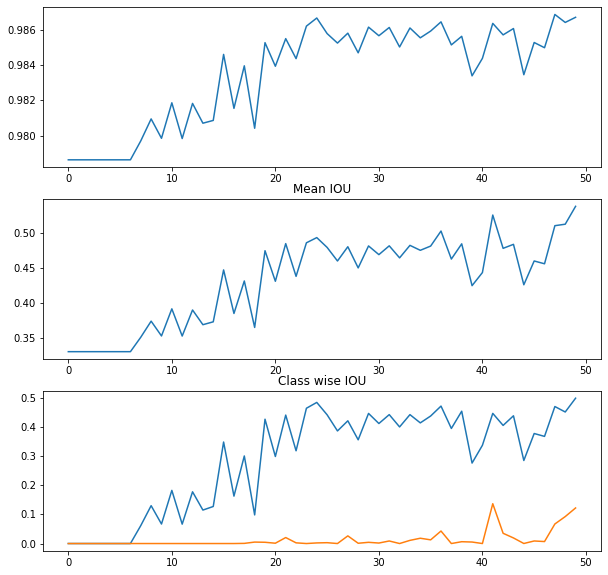

Mean IU 0.5379225149390888 50
Class wise IU [0.99303124 0.49908866 0.13674994]
Class wise IU best epoch [48 50 42]
Best epoch:  50


In [4]:

model_path = 'fcn_32_2021-10-01_130945.176372'
model_name = 'fcn_32'
max_epochs = 50
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name

best_epoch = find_best_model(checkpoints_path, max_epochs);
print('Best epoch: ', best_epoch)

loaded weights  logs\fcn_32_2021-10-01_130945.176372\checkpoints\fcn_32.00050


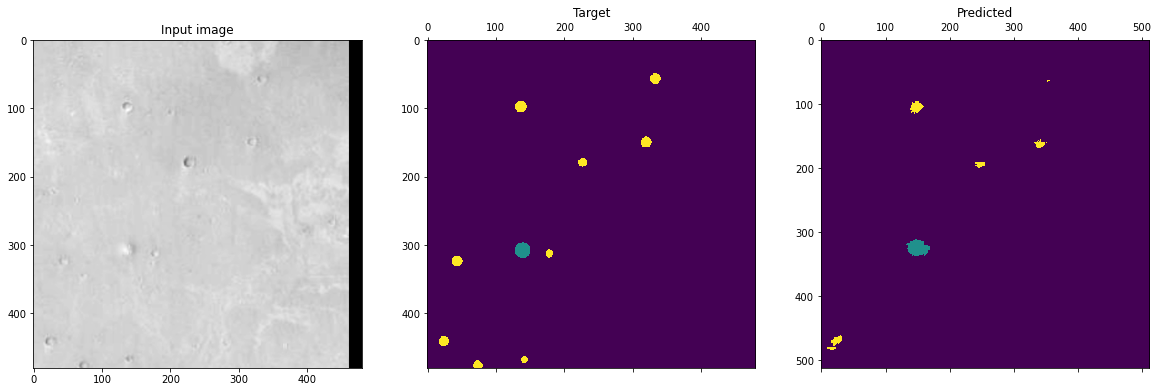

Output  0:   260729   99.460%, annotations   228588   99.214%
Output  1:      676    0.258%, annotations      414    0.180%
Output  2:      739    0.282%, annotations     1398    0.607%

Model:  fcn_32
Path:   logs\fcn_32_2021-10-01_130945.176372\checkpoints\fcn_32
Epoch:  50

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.53792 |  0.49909 |  0.12216
Test 0.1  |  0.47251 |  0.17144 |  0.25397
Test 0.05 |  0.37279 |  0.06404 |  0.06136


In [5]:
epoch = best_epoch
# epoch = 33
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

## FCN 8 VGG 50 epochs

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/50 [00:09<08:07,  9.94s/it]

  4%|███▎                                                                               | 2/50 [00:13<05:10,  6.47s/it]

  6%|████▉                                                                              | 3/50 [00:18<04:11,  5.35s/it]

  8%|██████▋                                                                            | 4/50 [00:22<03:44,  4.87s/it]

 10%|████████▎                                                                          | 5/50 [00:26<03:26,  4.58s/it]

 12%|█████████▉                                                                         | 6/50 [00:30<03:14,  4.41s/it]

 14%|███████████▌                                                                       | 7/50 [00:34<03:04,  4.29s/it]

 16%|█████████████▎                                                                     | 8/50 [00:38<02:57,  4.23s/it]

 18%|██████████████▉                                                                    | 9/50 [00:42<02:51,  4.18s/it]

 20%|████████████████▍                                                                 | 10/50 [00:46<02:46,  4.16s/it]

 22%|██████████████████                                                                | 11/50 [00:50<02:43,  4.18s/it]

 24%|███████████████████▋                                                              | 12/50 [00:54<02:37,  4.15s/it]

 26%|█████████████████████▎                                                            | 13/50 [00:58<02:32,  4.12s/it]

 28%|██████████████████████▉                                                           | 14/50 [01:02<02:27,  4.09s/it]

 30%|████████████████████████▌                                                         | 15/50 [01:07<02:22,  4.08s/it]

 32%|██████████████████████████▏                                                       | 16/50 [01:11<02:18,  4.08s/it]

 34%|███████████████████████████▉                                                      | 17/50 [01:15<02:14,  4.07s/it]

 36%|█████████████████████████████▌                                                    | 18/50 [01:19<02:09,  4.06s/it]

 38%|███████████████████████████████▏                                                  | 19/50 [01:23<02:08,  4.14s/it]

 40%|████████████████████████████████▊                                                 | 20/50 [01:27<02:03,  4.12s/it]

 42%|██████████████████████████████████▍                                               | 21/50 [01:31<01:58,  4.09s/it]

 44%|████████████████████████████████████                                              | 22/50 [01:35<01:54,  4.08s/it]

 46%|█████████████████████████████████████▋                                            | 23/50 [01:39<01:49,  4.06s/it]

 48%|███████████████████████████████████████▎                                          | 24/50 [01:43<01:45,  4.05s/it]

 50%|█████████████████████████████████████████                                         | 25/50 [01:47<01:41,  4.05s/it]

 52%|██████████████████████████████████████████▋                                       | 26/50 [01:51<01:37,  4.06s/it]

 54%|████████████████████████████████████████████▎                                     | 27/50 [01:55<01:33,  4.06s/it]

 56%|█████████████████████████████████████████████▉                                    | 28/50 [02:00<01:30,  4.12s/it]

 58%|███████████████████████████████████████████████▌                                  | 29/50 [02:04<01:26,  4.11s/it]

 60%|█████████████████████████████████████████████████▏                                | 30/50 [02:08<01:21,  4.10s/it]

 62%|██████████████████████████████████████████████████▊                               | 31/50 [02:12<01:17,  4.08s/it]

 64%|████████████████████████████████████████████████████▍                             | 32/50 [02:16<01:13,  4.06s/it]

 66%|██████████████████████████████████████████████████████                            | 33/50 [02:20<01:09,  4.06s/it]

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [02:24<01:04,  4.06s/it]

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [02:28<01:00,  4.05s/it]

 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:32<00:56,  4.06s/it]

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:36<00:52,  4.05s/it]

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:40<00:49,  4.12s/it]

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:45<00:45,  4.10s/it]

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:49<00:40,  4.09s/it]

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:53<00:36,  4.06s/it]

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:57<00:32,  4.03s/it]

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [03:01<00:28,  4.04s/it]

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [03:05<00:24,  4.02s/it]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [03:09<00:20,  4.01s/it]

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [03:13<00:16,  4.01s/it]

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [03:17<00:12,  4.01s/it]

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [03:21<00:08,  4.01s/it]

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [03:25<00:04,  4.09s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:29<00:00,  4.19s/it]


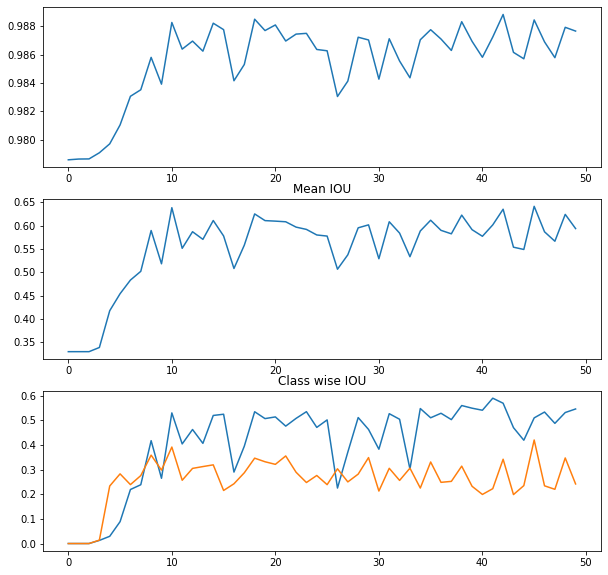

Mean IU 0.6411349976777267 46
Class wise IU [0.99375423 0.58955465 0.42001288]
Class wise IU best epoch [46 42 46]
Best epoch:  46


In [4]:
model_path = 'fcn_8_vgg_2021-10-02_221245.892861'
model_name = 'fcn_8_vgg'
max_epochs = 50
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name

best_epoch = find_best_model(checkpoints_path, max_epochs);
print('Best epoch: ', best_epoch)

loaded weights  logs\fcn_8_vgg_2021-10-02_221245.892861\checkpoints\fcn_8_vgg.00046


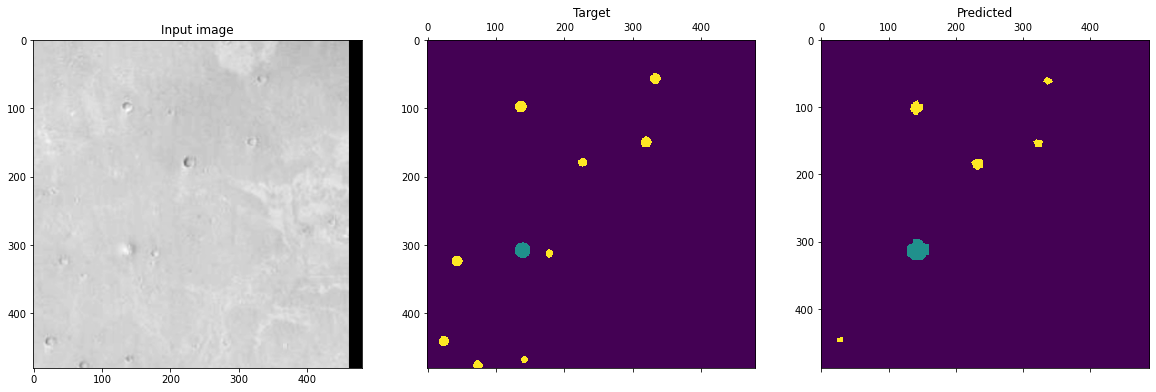

Output  0:   236566   99.337%, annotations   228588   99.214%
Output  1:      807    0.339%, annotations      414    0.180%
Output  2:      771    0.324%, annotations     1398    0.607%

Model:  fcn_8_vgg
Path:   logs\fcn_8_vgg_2021-10-02_221245.892861\checkpoints\fcn_8_vgg
Epoch:  46

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.64113 |  0.50964 |  0.42001
Test 0.1  |  0.55985 |  0.26441 |  0.42330
Test 0.05 |  0.42408 |  0.08407 |  0.19435


In [3]:
model_path = 'fcn_8_vgg_2021-10-02_221245.892861'
model_name = 'fcn_8_vgg'
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name
# epoch = best_epoch
epoch = 46
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

loaded weights  logs\fcn_8_vgg_2021-10-02_221245.892861\checkpoints\fcn_8_vgg.00042


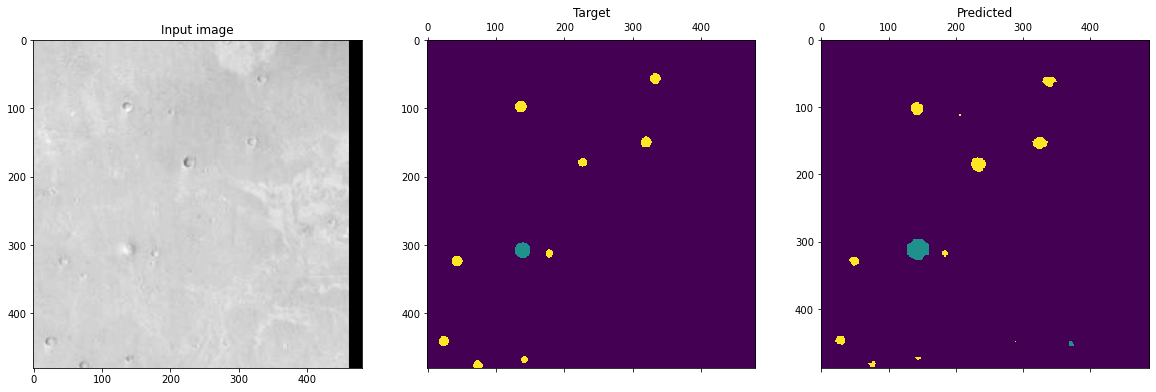

Output  0:   235647   98.951%, annotations   228588   99.214%
Output  1:      871    0.366%, annotations      414    0.180%
Output  2:     1626    0.683%, annotations     1398    0.607%

Model:  fcn_8_vgg
Path:   logs\fcn_8_vgg_2021-10-02_221245.892861\checkpoints\fcn_8_vgg
Epoch:  42

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.60138 |  0.58955 |  0.22253
Test 0.1  |  0.52878 |  0.14595 |  0.44884
Test 0.05 |  0.43677 |  0.11922 |  0.19699


In [4]:
# epoch = best_epoch
epoch = 42
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

## FCN 32 VGG

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/50 [00:09<08:04,  9.89s/it]

  4%|███▎                                                                               | 2/50 [00:13<05:08,  6.43s/it]

  6%|████▉                                                                              | 3/50 [00:17<04:11,  5.34s/it]

  8%|██████▋                                                                            | 4/50 [00:22<03:42,  4.85s/it]

 10%|████████▎                                                                          | 5/50 [00:26<03:27,  4.60s/it]

 12%|█████████▉                                                                         | 6/50 [00:30<03:13,  4.40s/it]

 14%|███████████▌                                                                       | 7/50 [00:34<03:05,  4.31s/it]

 16%|█████████████▎                                                                     | 8/50 [00:38<02:59,  4.26s/it]

 18%|██████████████▉                                                                    | 9/50 [00:42<02:52,  4.21s/it]

 20%|████████████████▍                                                                 | 10/50 [00:46<02:46,  4.17s/it]

 22%|██████████████████                                                                | 11/50 [00:50<02:42,  4.17s/it]

 24%|███████████████████▋                                                              | 12/50 [00:54<02:37,  4.15s/it]

 26%|█████████████████████▎                                                            | 13/50 [00:59<02:33,  4.15s/it]

 28%|██████████████████████▉                                                           | 14/50 [01:03<02:31,  4.21s/it]

 30%|████████████████████████▌                                                         | 15/50 [01:07<02:26,  4.20s/it]

 32%|██████████████████████████▏                                                       | 16/50 [01:11<02:22,  4.20s/it]

 34%|███████████████████████████▉                                                      | 17/50 [01:15<02:18,  4.18s/it]

 36%|█████████████████████████████▌                                                    | 18/50 [01:20<02:13,  4.17s/it]

 38%|███████████████████████████████▏                                                  | 19/50 [01:24<02:09,  4.17s/it]

 40%|████████████████████████████████▊                                                 | 20/50 [01:28<02:04,  4.15s/it]

 42%|██████████████████████████████████▍                                               | 21/50 [01:32<02:00,  4.16s/it]

 44%|████████████████████████████████████                                              | 22/50 [01:36<01:56,  4.16s/it]

 46%|█████████████████████████████████████▋                                            | 23/50 [01:41<01:53,  4.22s/it]

 48%|███████████████████████████████████████▎                                          | 24/50 [01:45<01:49,  4.20s/it]

 50%|█████████████████████████████████████████                                         | 25/50 [01:49<01:45,  4.20s/it]

 52%|██████████████████████████████████████████▋                                       | 26/50 [01:53<01:40,  4.19s/it]

 54%|████████████████████████████████████████████▎                                     | 27/50 [01:57<01:36,  4.19s/it]

 56%|█████████████████████████████████████████████▉                                    | 28/50 [02:01<01:31,  4.15s/it]

 58%|███████████████████████████████████████████████▌                                  | 29/50 [02:06<01:27,  4.16s/it]

 60%|█████████████████████████████████████████████████▏                                | 30/50 [02:10<01:23,  4.15s/it]

 62%|██████████████████████████████████████████████████▊                               | 31/50 [02:14<01:18,  4.13s/it]

 64%|████████████████████████████████████████████████████▍                             | 32/50 [02:18<01:14,  4.14s/it]

 66%|██████████████████████████████████████████████████████                            | 33/50 [02:22<01:10,  4.15s/it]

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [02:27<01:07,  4.23s/it]

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [02:31<01:02,  4.19s/it]

 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:35<00:58,  4.17s/it]

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:39<00:54,  4.16s/it]

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:43<00:49,  4.15s/it]

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:47<00:45,  4.13s/it]

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:51<00:41,  4.14s/it]

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:55<00:37,  4.16s/it]

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [03:00<00:33,  4.16s/it]

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [03:04<00:29,  4.17s/it]

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [03:08<00:25,  4.18s/it]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [03:12<00:20,  4.16s/it]

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [03:17<00:16,  4.23s/it]

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [03:21<00:12,  4.22s/it]

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [03:25<00:08,  4.19s/it]

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [03:29<00:04,  4.18s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:33<00:00,  4.27s/it]


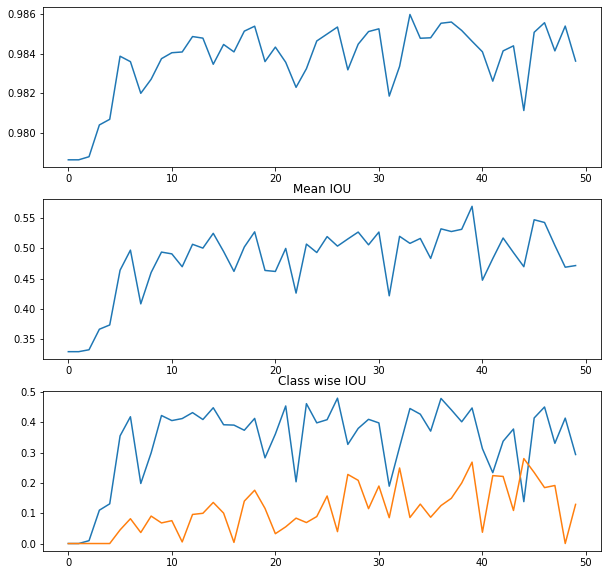

Mean IU 0.5687148639588872 40
Class wise IU [0.99235013 0.47926656 0.28016869]
Class wise IU best epoch [34 27 45]
Best epoch:  40


In [4]:
model_path = 'fcn_32_vgg_2021-10-03_162512.438811'
model_name = 'fcn_32_vgg'
max_epochs = 50
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name

best_epoch = find_best_model(checkpoints_path, max_epochs);
print('Best epoch: ', best_epoch)

loaded weights  logs\fcn_32_vgg_2021-10-03_162512.438811\checkpoints\fcn_32_vgg.00040


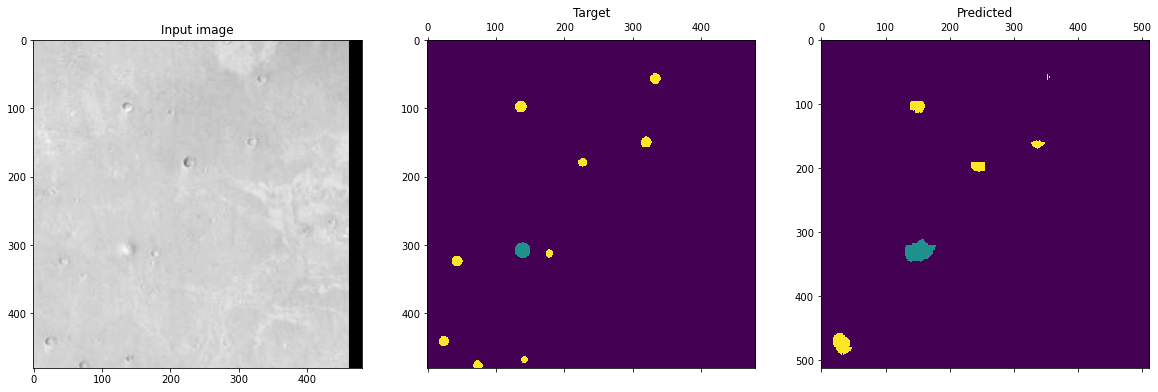

Output  0:   259427   98.964%, annotations   228588   99.214%
Output  1:     1164    0.444%, annotations      414    0.180%
Output  2:     1553    0.592%, annotations     1398    0.607%

Model:  fcn_32_vgg
Path:   logs\fcn_32_vgg_2021-10-03_162512.438811\checkpoints\fcn_32_vgg
Epoch:  40

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.56871 |  0.44700 |  0.26844
Test 0.1  |  0.49023 |  0.14139 |  0.33876
Test 0.05 |  0.38945 |  0.03894 |  0.13726


In [5]:

epoch = best_epoch
# epoch = 46
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

loaded weights  logs\fcn_32_vgg_2021-10-03_162512.438811\checkpoints\fcn_32_vgg.00027


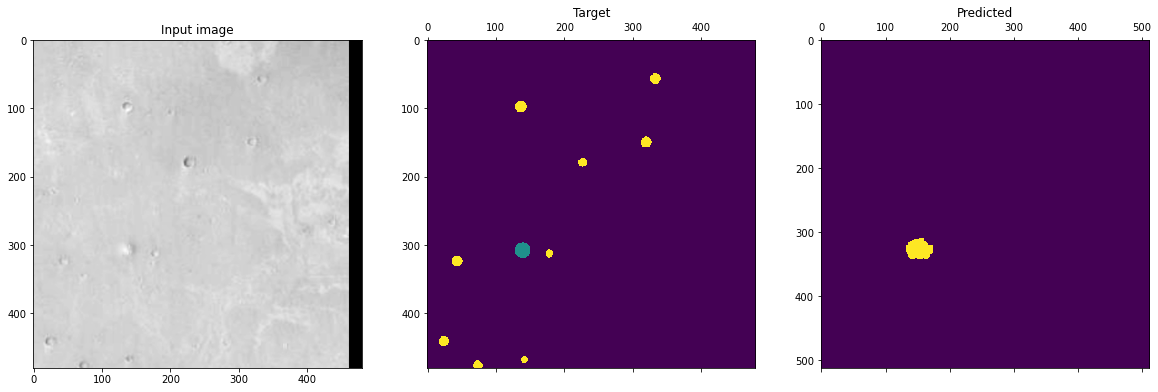

Output  0:   261077   99.593%, annotations   228588   99.214%
Output  1:     1067    0.407%, annotations      414    0.180%
Output  2:        0    0.000%, annotations     1398    0.607%

Model:  fcn_32_vgg
Path:   logs\fcn_32_vgg_2021-10-03_162512.438811\checkpoints\fcn_32_vgg
Epoch:  27

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.50331 |  0.47927 |  0.03921
Test 0.1  |  0.45007 |  0.15525 |  0.20377
Test 0.05 |  0.36120 |  0.02750 |  0.06365


In [6]:

# epoch = best_epoch
epoch = 27
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

loaded weights  logs\fcn_32_vgg_2021-10-03_162512.438811\checkpoints\fcn_32_vgg.00045


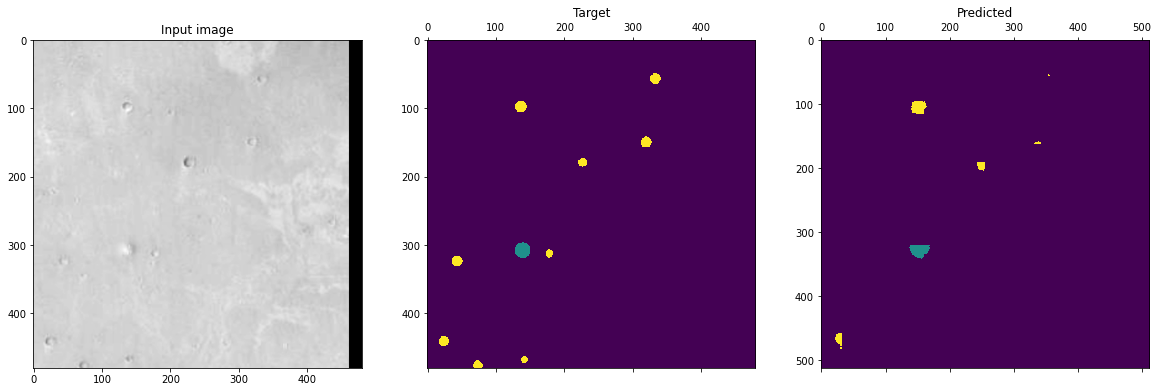

Output  0:   260871   99.514%, annotations   228588   99.214%
Output  1:      521    0.199%, annotations      414    0.180%
Output  2:      752    0.287%, annotations     1398    0.607%

Model:  fcn_32_vgg
Path:   logs\fcn_32_vgg_2021-10-03_162512.438811\checkpoints\fcn_32_vgg
Epoch:  45

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.46945 |  0.13811 |  0.28017
Test 0.1  |  0.44948 |  0.07295 |  0.28326
Test 0.05 |  0.38839 |  0.01792 |  0.15349


In [7]:

# epoch = best_epoch
epoch = 45
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

## pspnet 

Note: inputs with different shape (input % 192)

Low accuracy of cones segmentations, probably more epoches neded

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:35<00:00,  1.90s/it]


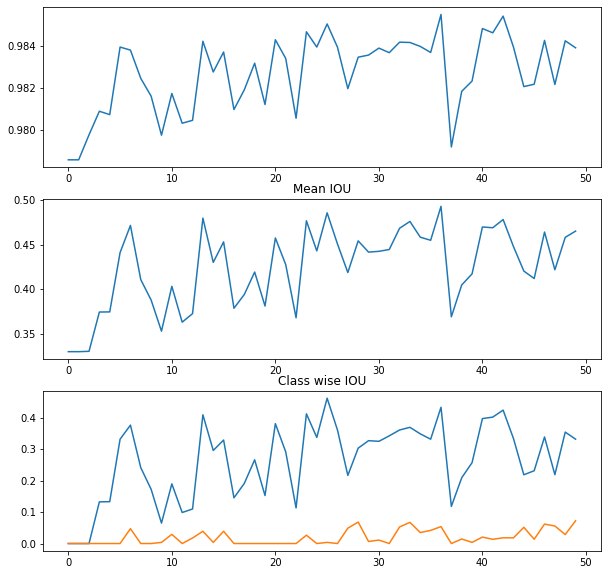

Mean IU 0.493112172690994 37
Class wise IU [0.99212311 0.46236559 0.07241379]
Class wise IU best epoch [43 26 50]
Best epoch:  37


In [4]:
model_path = 'pspnet_2021-10-04_151908.573543'
model_name = 'pspnet'
max_epochs = 50
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name

best_epoch = find_best_model(checkpoints_path, max_epochs);
print('Best epoch: ', best_epoch)

loaded weights  logs\pspnet_2021-10-04_151908.573543\checkpoints\pspnet.00037


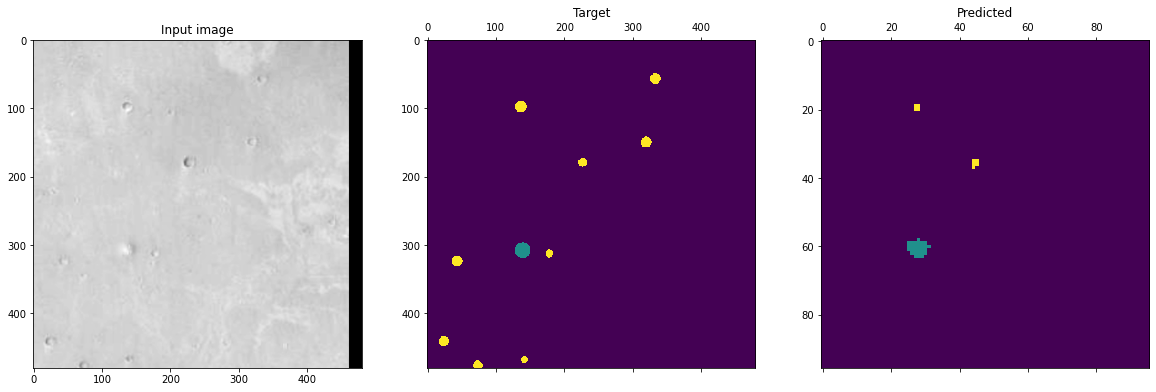

Output  0:     9179   99.599%, annotations   228588   99.214%
Output  1:       28    0.304%, annotations      414    0.180%
Output  2:        9    0.098%, annotations     1398    0.607%

Model:  pspnet
Path:   logs\pspnet_2021-10-04_151908.573543\checkpoints\pspnet
Epoch:  37

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.49311 |  0.43340 |  0.05387
Test 0.1  |  0.43806 |  0.12685 |  0.19588
Test 0.05 |  0.34399 |  0.00000 |  0.03951


In [5]:

epoch = best_epoch
# epoch = 45
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

loaded weights  logs\pspnet_2021-10-04_151908.573543\checkpoints\pspnet.00050


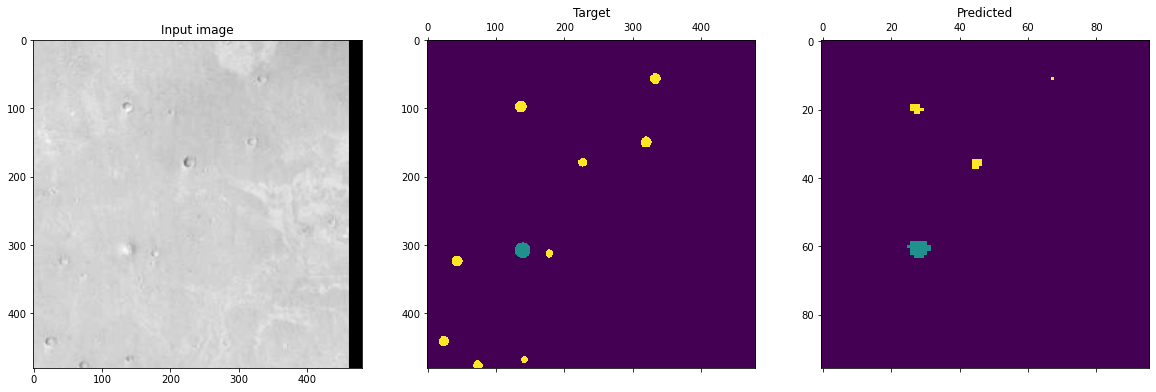

Output  0:     9172   99.523%, annotations   228588   99.214%
Output  1:       26    0.282%, annotations      414    0.180%
Output  2:       18    0.195%, annotations     1398    0.607%

Model:  pspnet
Path:   logs\pspnet_2021-10-04_151908.573543\checkpoints\pspnet
Epoch:  50

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.46526 |  0.33198 |  0.07241
Test 0.1  |  0.43022 |  0.12458 |  0.17457
Test 0.05 |  0.33350 |  0.00000 |  0.00777


In [6]:

# epoch = best_epoch
epoch = 50
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

## pspnet 50 (33 epochs)

Note: works only fro input_shape == (473, 473) or  (713, 713):

Configuration used:
``` python
model = pspnet.pspnet_50( n_classes=3, input_height=473, input_width=473, channels=1 )
```



Crush in 32 epoch:
```
 Unknown: AssertionError: Expected number of channels to be three, got 1 channels (shape (480, 480, 1)).
Traceback (most recent call last):

  File "C:\Users\grochu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\script_ops.py", line 244, in __call__
    ret = func(*args)

  File "C:\Users\grochu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\autograph\impl\api.py", line 302, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\grochu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 827, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\grochu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 814, in wrapped_generator
    for data in generator_fn():

  File "D:\_Users\grochu\mars\marscc\keras_segmentation_mod\data_utils\data_loader.py", line 287, in image_segmentation_generator
```



100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [03:40<00:00,  6.89s/it]


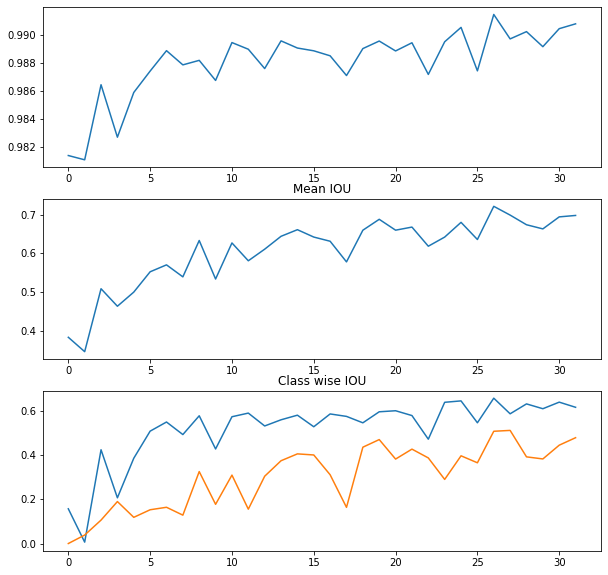

Mean IU 0.7211383080905575 27
Class wise IU [0.9952809  0.65906525 0.51296435]
Class wise IU best epoch [27 27 28]
Best epoch:  27


In [6]:
model_path = 'pspnet_50_2021-10-06_120844.911856'
model_name = 'pspnet_50'
max_epochs = 32
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name

best_epoch = find_best_model(checkpoints_path, max_epochs);
print('Best epoch: ', best_epoch)

loaded weights  logs\pspnet_50_2021-10-06_120844.911856\checkpoints\pspnet_50.00027


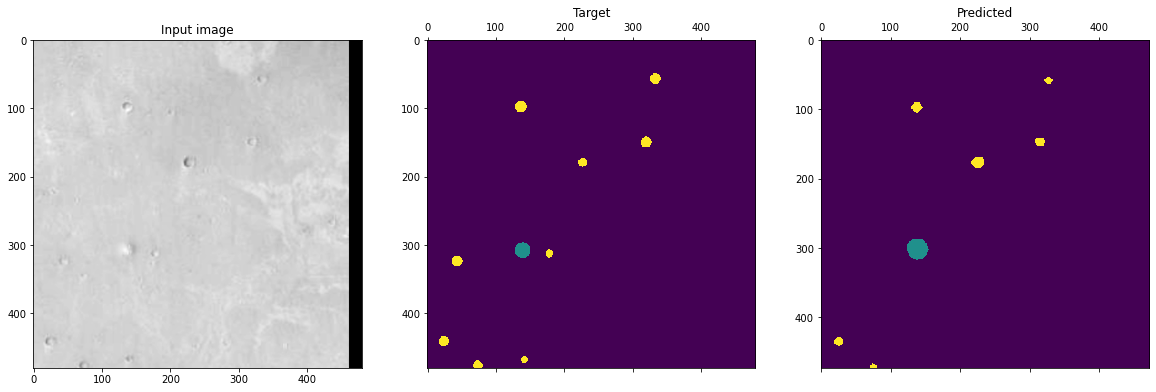

Output  0:   222154   99.296%, annotations   228588   99.214%
Output  1:      737    0.329%, annotations      414    0.180%
Output  2:      838    0.375%, annotations     1398    0.607%

Model:  pspnet_50
Path:   logs\pspnet_50_2021-10-06_120844.911856\checkpoints\pspnet_50
Epoch:  27

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.72114 |  0.65907 |  0.50907
Test 0.1  |  0.57276 |  0.21875 |  0.50522
Test 0.05 |  0.45763 |  0.08991 |  0.28855


In [7]:

epoch = best_epoch
# epoch = 50
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

## pspnet_50 (50 epochs)

fixed by removing problematic augmentation transformation

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:39<00:00,  6.78s/it]


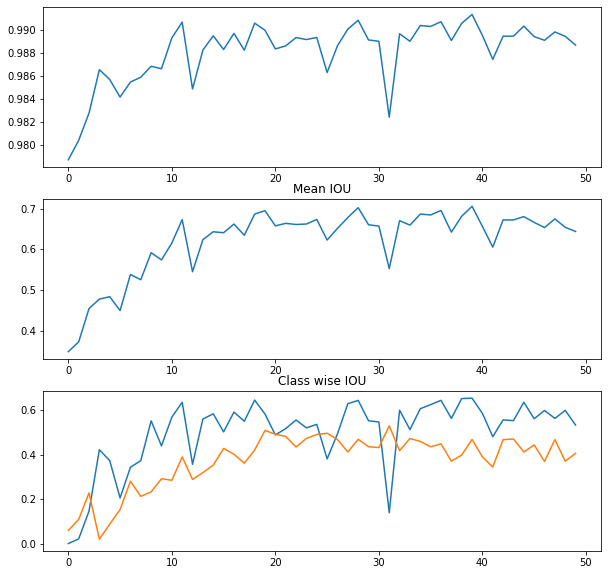

Mean IU 0.7056983615277598 40
Class wise IU [0.99524214 0.65349986 0.5292212 ]
Class wise IU best epoch [40 40 32]
Best epoch:  40


In [3]:
model_path = 'pspnet_50_2021-10-08_001801.417427'
model_name = 'pspnet_50'
max_epochs = 50
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name

best_epoch = find_best_model(checkpoints_path, max_epochs);
print('Best epoch: ', best_epoch)

loaded weights  logs\pspnet_50_2021-10-08_001801.417427\checkpoints\pspnet_50.00040
Model: pspnet_50, Input (None, 473, 473, 1) -> Output (None, 223729, 3)


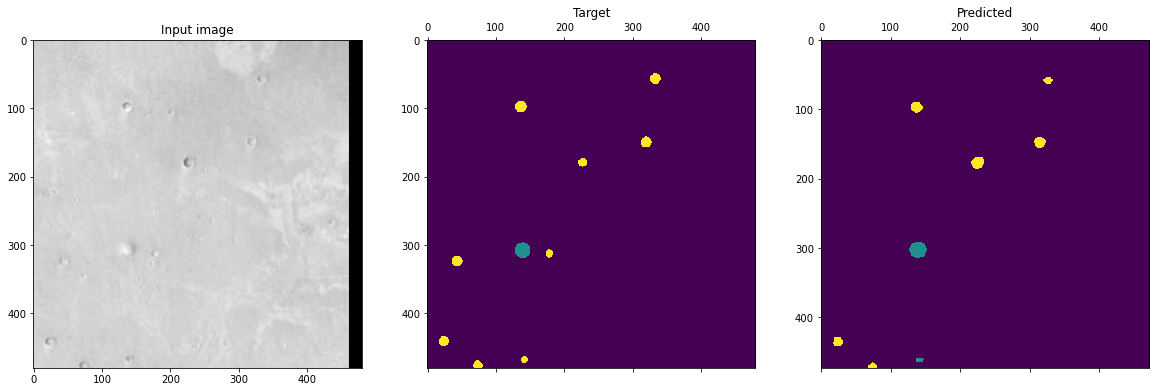

Output  0:   222189   99.312%, annotations   228588   99.214%
Output  1:      521    0.233%, annotations      414    0.180%
Output  2:     1019    0.455%, annotations     1398    0.607%

Model:  pspnet_50
Path:   logs\pspnet_50_2021-10-08_001801.417427\checkpoints\pspnet_50
Epoch:  40

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.70570 |  0.65350 |  0.46835
Test 0.1  |  0.55565 |  0.12541 |  0.54786
Test 0.05 |  0.44911 |  0.08539 |  0.26718


In [4]:

epoch = best_epoch
# epoch = 50
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

loaded weights  logs\pspnet_50_2021-10-08_001801.417427\checkpoints\pspnet_50.00032
Model: pspnet_50, Input (None, 473, 473, 1) -> Output (None, 223729, 3)


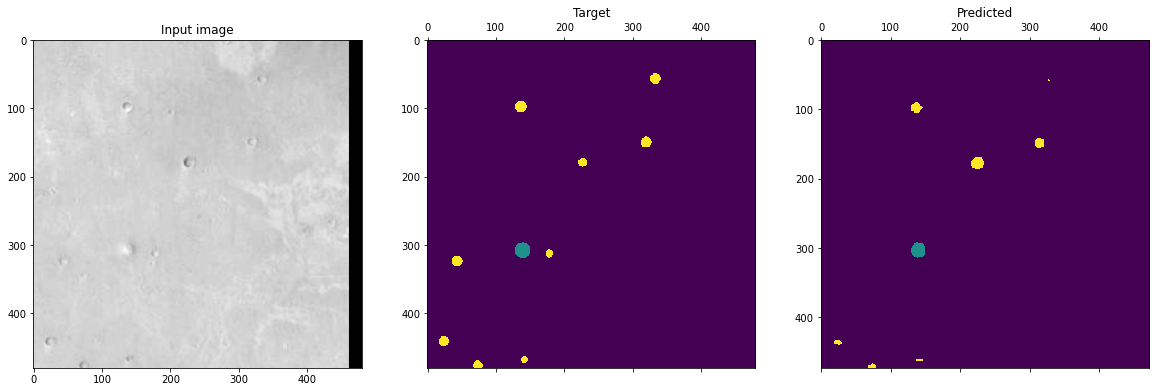

Output  0:   222599   99.495%, annotations   228588   99.214%
Output  1:      360    0.161%, annotations      414    0.180%
Output  2:      770    0.344%, annotations     1398    0.607%

Model:  pspnet_50
Path:   logs\pspnet_50_2021-10-08_001801.417427\checkpoints\pspnet_50
Epoch:  32

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.55295 |  0.13856 |  0.52922
Test 0.1  |  0.54226 |  0.10484 |  0.52783
Test 0.05 |  0.43668 |  0.04078 |  0.27463


In [5]:

# epoch = best_epoch
epoch = 32
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

## pspnet_101

```python

model.train(
    train_images =  "data/mars_data_20210923/train/images/",
    train_annotations = "data/mars_data_20210923/train/annotations/",
    optimizer_name=optimizer_name,
    batch_size = 8,
    steps_per_epoch = 1024,
    checkpoints_path =str( checkpoint_path / model.model_name ) ,
    epochs=50,
    val_images = "data/mars_data_20210923/val/images/",
    val_annotations = "data/mars_data_20210923/val/annotations",
    validate=True,
    val_steps_per_epoch=512,
    callbacks=callbacks,
    read_image_type=0,
    do_augment=True,
    ignore_zero_class=False
)
```

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [10:49<00:00, 12.99s/it]


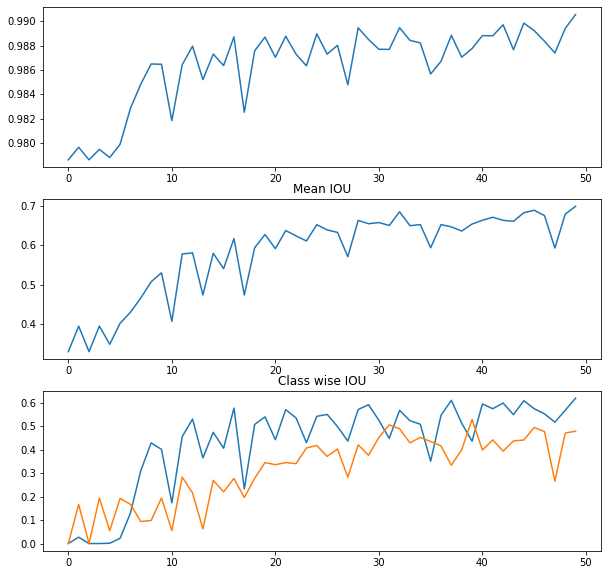

Mean IU 0.6984602527385465 50
Class wise IU [0.99475336 0.62085318 0.53000135]
Class wise IU best epoch [50 50 40]
Best epoch:  50


In [3]:
model_path = 'pspnet_101_2021-10-11_225727.630419'
model_name = 'pspnet_101'
max_epochs = 50
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name

best_epoch = find_best_model(checkpoints_path, max_epochs);
print('Best epoch: ', best_epoch)

loaded weights  logs\pspnet_101_2021-10-11_225727.630419\checkpoints\pspnet_101.00050
Model: pspnet_101, Input (None, 473, 473, 1) -> Output (None, 223729, 3)


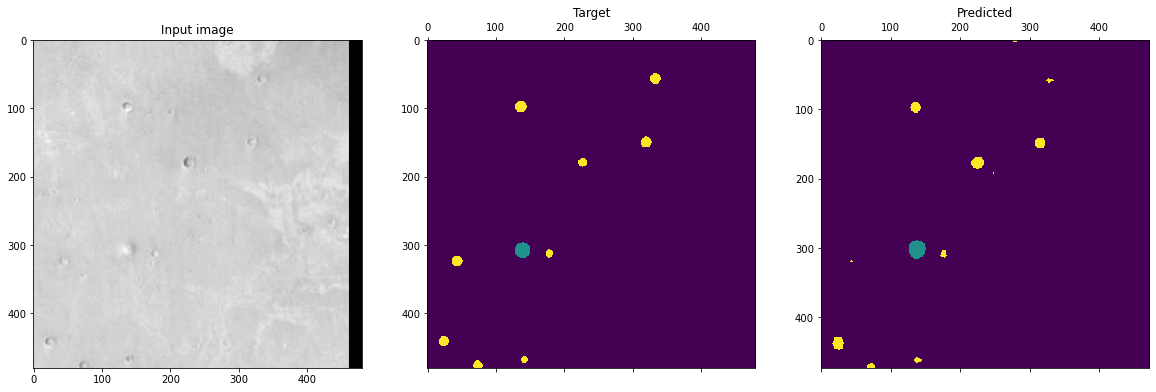

Output  0:   222049   99.249%, annotations   228588   99.214%
Output  1:      528    0.236%, annotations      414    0.180%
Output  2:     1152    0.515%, annotations     1398    0.607%

Model:  pspnet_101
Path:   logs\pspnet_101_2021-10-11_225727.630419\checkpoints\pspnet_101
Epoch:  50

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.69846 |  0.62085 |  0.47977
Test 0.1  |  0.60088 |  0.22577 |  0.58257
Test 0.05 |  0.45805 |  0.06066 |  0.31855


In [4]:
epoch = best_epoch
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

loaded weights  logs\pspnet_101_2021-10-11_225727.630419\checkpoints\pspnet_101.00040
Model: pspnet_101, Input (None, 473, 473, 1) -> Output (None, 223729, 3)


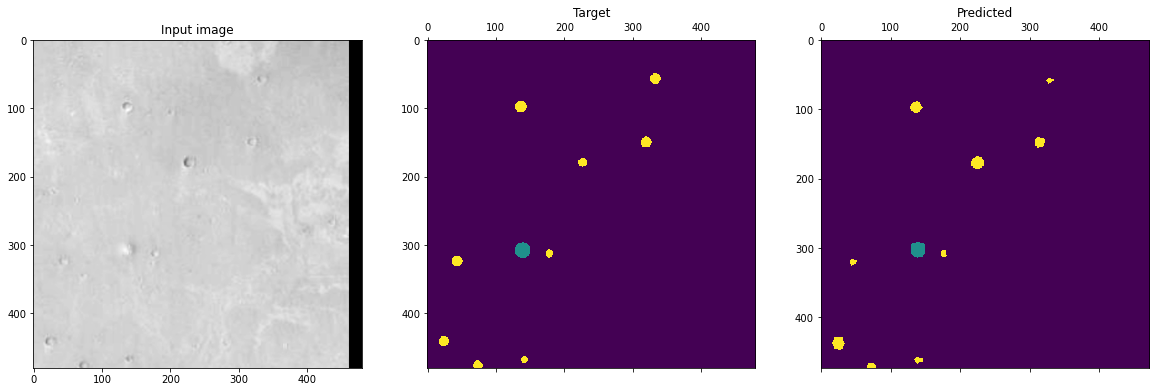

Output  0:   222042   99.246%, annotations   228588   99.214%
Output  1:      395    0.177%, annotations      414    0.180%
Output  2:     1292    0.577%, annotations     1398    0.607%

Model:  pspnet_101
Path:   logs\pspnet_101_2021-10-11_225727.630419\checkpoints\pspnet_101
Epoch:  40

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.65356 |  0.43706 |  0.53000
Test 0.1  |  0.56550 |  0.13469 |  0.56766
Test 0.05 |  0.42072 |  0.02280 |  0.24448


In [5]:
epoch = 40
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

## segnet 50 epochs

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:37<00:00,  1.95s/it]


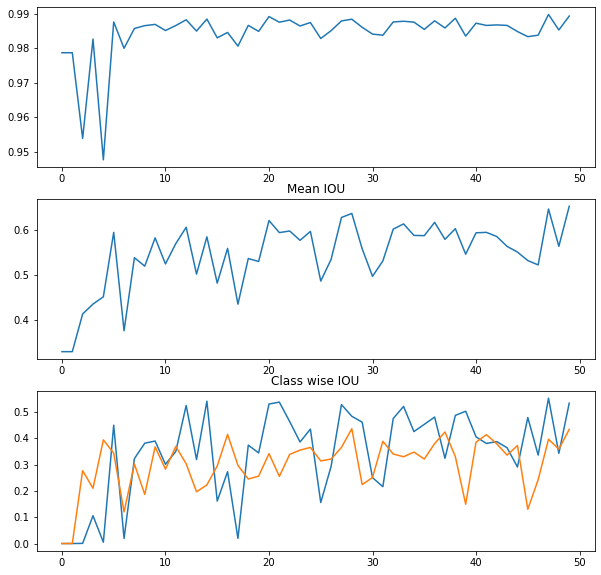

Mean IU 0.6537207296481469 50
Class wise IU [0.99470611 0.55227769 0.43626943]
Class wise IU best epoch [48 48 29]
Best epoch:  50


In [5]:

model_path = 'segnet_2021-10-13_101102.165508'
model_name = 'segnet'
max_epochs = 50
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name

best_epoch = find_best_model(checkpoints_path, max_epochs);
print('Best epoch: ', best_epoch)

loaded weights  logs\segnet_2021-10-13_101102.165508\checkpoints\segnet.00050


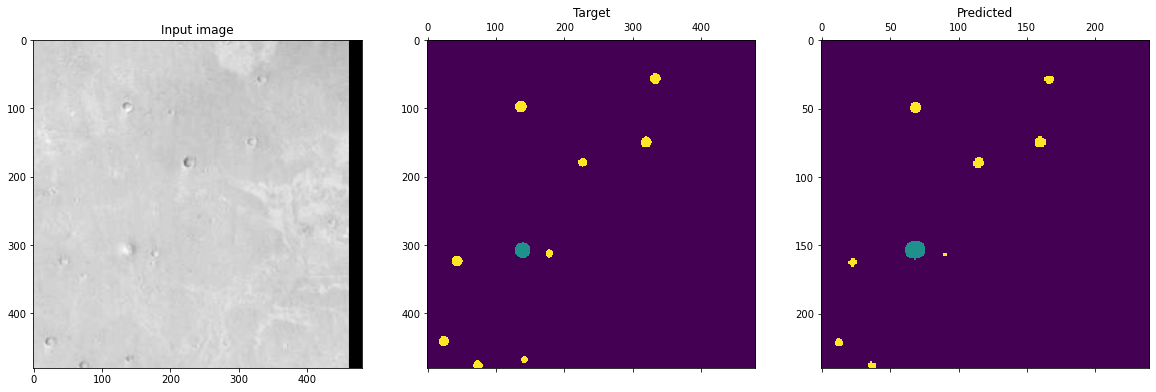

Output  0:    57164   99.243%, annotations   228588   99.214%
Output  1:      162    0.281%, annotations      414    0.180%
Output  2:      274    0.476%, annotations     1398    0.607%

Model:  segnet
Path:   logs\segnet_2021-10-13_101102.165508\checkpoints\segnet
Epoch:  50

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.65372 |  0.53332 |  0.43347
Test 0.1  |  0.57954 |  0.25655 |  0.48808
Test 0.05 |  0.43892 |  0.12992 |  0.19346


In [8]:
epoch = best_epoch
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

## vgg_segnet default

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/50 [00:02<01:59,  2.43s/it]

  4%|███▎                                                                               | 2/50 [00:04<01:46,  2.21s/it]

  6%|████▉                                                                              | 3/50 [00:06<01:40,  2.15s/it]

  8%|██████▋                                                                            | 4/50 [00:08<01:36,  2.10s/it]

 10%|████████▎                                                                          | 5/50 [00:10<01:34,  2.10s/it]

 12%|█████████▉                                                                         | 6/50 [00:12<01:32,  2.09s/it]

 14%|███████████▌                                                                       | 7/50 [00:14<01:29,  2.08s/it]

 16%|█████████████▎                                                                     | 8/50 [00:16<01:27,  2.08s/it]

 18%|██████████████▉                                                                    | 9/50 [00:18<01:24,  2.07s/it]

 20%|████████████████▍                                                                 | 10/50 [00:21<01:22,  2.07s/it]

 22%|██████████████████                                                                | 11/50 [00:23<01:21,  2.08s/it]

 24%|███████████████████▋                                                              | 12/50 [00:25<01:22,  2.16s/it]

 26%|█████████████████████▎                                                            | 13/50 [00:27<01:18,  2.13s/it]

 28%|██████████████████████▉                                                           | 14/50 [00:29<01:16,  2.12s/it]

 30%|████████████████████████▌                                                         | 15/50 [00:31<01:13,  2.10s/it]

 32%|██████████████████████████▏                                                       | 16/50 [00:33<01:11,  2.10s/it]

 34%|███████████████████████████▉                                                      | 17/50 [00:35<01:08,  2.09s/it]

 36%|█████████████████████████████▌                                                    | 18/50 [00:37<01:06,  2.08s/it]

 38%|███████████████████████████████▏                                                  | 19/50 [00:39<01:04,  2.07s/it]

 40%|████████████████████████████████▊                                                 | 20/50 [00:41<01:01,  2.06s/it]

 42%|██████████████████████████████████▍                                               | 21/50 [00:44<00:59,  2.06s/it]

 44%|████████████████████████████████████                                              | 22/50 [00:46<00:57,  2.06s/it]

 46%|█████████████████████████████████████▋                                            | 23/50 [00:48<00:55,  2.06s/it]

 48%|███████████████████████████████████████▎                                          | 24/50 [00:50<00:53,  2.06s/it]

 50%|█████████████████████████████████████████                                         | 25/50 [00:52<00:51,  2.06s/it]

 52%|██████████████████████████████████████████▋                                       | 26/50 [00:54<00:51,  2.16s/it]

 54%|████████████████████████████████████████████▎                                     | 27/50 [00:56<00:49,  2.13s/it]

 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:58<00:46,  2.11s/it]

 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:00<00:44,  2.10s/it]

 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:02<00:41,  2.09s/it]

 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:05<00:39,  2.09s/it]

 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:07<00:37,  2.08s/it]

 66%|██████████████████████████████████████████████████████                            | 33/50 [01:09<00:35,  2.07s/it]

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:11<00:33,  2.06s/it]

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:13<00:30,  2.06s/it]

 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:15<00:28,  2.07s/it]

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:17<00:26,  2.08s/it]

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:19<00:24,  2.07s/it]

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:21<00:22,  2.07s/it]

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:23<00:20,  2.07s/it]

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:25<00:18,  2.07s/it]

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:28<00:17,  2.20s/it]

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:30<00:15,  2.16s/it]

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:32<00:12,  2.13s/it]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:34<00:10,  2.12s/it]

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:36<00:08,  2.11s/it]

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:38<00:06,  2.10s/it]

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:40<00:04,  2.10s/it]

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:42<00:02,  2.09s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:44<00:00,  2.10s/it]


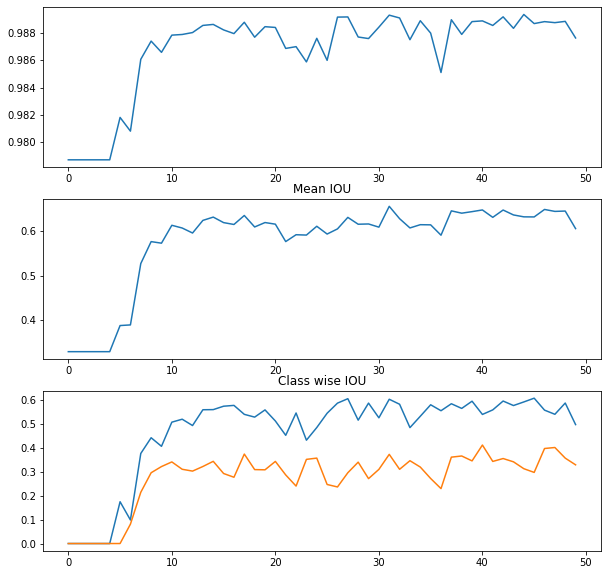

Mean IU 0.6560577067056493 32
Class wise IU [0.9941533  0.60662542 0.41108132]
Class wise IU best epoch [35 46 41]
Best epoch:  32


In [5]:
model_path = 'vgg_segnet_2021-10-14_123641.479849'
model_name = 'vgg_segnet'
max_epochs = 50
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name

best_epoch = find_best_model(checkpoints_path, max_epochs);
print('Best epoch: ', best_epoch)

loaded weights  logs\vgg_segnet_2021-10-14_123641.479849\checkpoints\vgg_segnet.00032


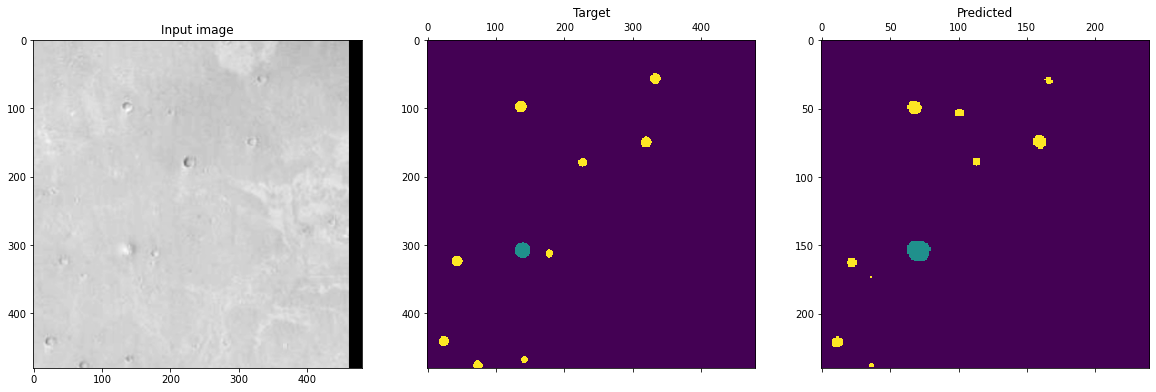

Output  0:    57058   99.059%, annotations   228588   99.214%
Output  1:      210    0.365%, annotations      414    0.180%
Output  2:      332    0.576%, annotations     1398    0.607%

Model:  vgg_segnet
Path:   logs\vgg_segnet_2021-10-14_123641.479849\checkpoints\vgg_segnet
Epoch:  32

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.65606 |  0.60215 |  0.37220
Test 0.1  |  0.50458 |  0.16694 |  0.35467
Test 0.05 |  0.41875 |  0.14530 |  0.11607


In [6]:
epoch = best_epoch
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

loaded weights  logs\vgg_segnet_2021-10-14_123641.479849\checkpoints\vgg_segnet.00046


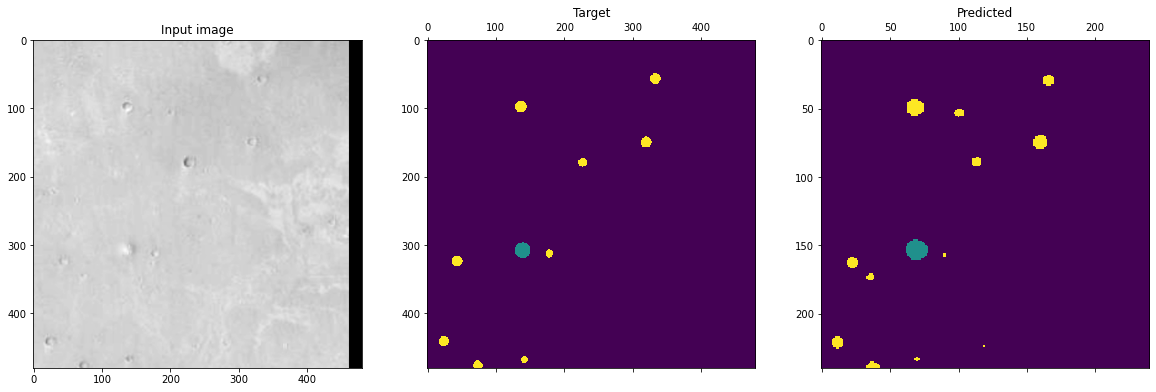

Output  0:    56893   98.773%, annotations   228588   99.214%
Output  1:      188    0.326%, annotations      414    0.180%
Output  2:      519    0.901%, annotations     1398    0.607%

Model:  vgg_segnet
Path:   logs\vgg_segnet_2021-10-14_123641.479849\checkpoints\vgg_segnet
Epoch:  46

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.63224 |  0.60663 |  0.29684
Test 0.1  |  0.55464 |  0.20763 |  0.46369
Test 0.05 |  0.45242 |  0.08864 |  0.27375


In [7]:
epoch = 46
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

## resnet50_segnet default

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/50 [00:11<09:01, 11.05s/it]

  4%|███▎                                                                               | 2/50 [00:16<06:03,  7.56s/it]

  6%|████▉                                                                              | 3/50 [00:21<05:00,  6.40s/it]

  8%|██████▋                                                                            | 4/50 [00:26<04:31,  5.91s/it]

 10%|████████▎                                                                          | 5/50 [00:31<04:10,  5.57s/it]

 12%|█████████▉                                                                         | 6/50 [00:36<03:59,  5.44s/it]

 14%|███████████▌                                                                       | 7/50 [00:41<03:47,  5.30s/it]

 16%|█████████████▎                                                                     | 8/50 [00:46<03:41,  5.28s/it]

 18%|██████████████▉                                                                    | 9/50 [00:51<03:32,  5.18s/it]

 20%|████████████████▍                                                                 | 10/50 [00:56<03:28,  5.20s/it]

 22%|██████████████████                                                                | 11/50 [01:01<03:20,  5.14s/it]

 24%|███████████████████▋                                                              | 12/50 [01:06<03:13,  5.09s/it]

 26%|█████████████████████▎                                                            | 13/50 [01:12<03:10,  5.15s/it]

 28%|██████████████████████▉                                                           | 14/50 [01:17<03:03,  5.11s/it]

 30%|████████████████████████▌                                                         | 15/50 [01:22<02:57,  5.08s/it]

 32%|██████████████████████████▏                                                       | 16/50 [01:27<02:52,  5.06s/it]

 34%|███████████████████████████▉                                                      | 17/50 [01:32<02:50,  5.16s/it]

 36%|█████████████████████████████▌                                                    | 18/50 [01:37<02:44,  5.14s/it]

 38%|███████████████████████████████▏                                                  | 19/50 [01:42<02:38,  5.10s/it]

 40%|████████████████████████████████▊                                                 | 20/50 [01:47<02:32,  5.08s/it]

 42%|██████████████████████████████████▍                                               | 21/50 [01:53<02:30,  5.19s/it]

 44%|████████████████████████████████████                                              | 22/50 [01:58<02:23,  5.14s/it]

 46%|█████████████████████████████████████▋                                            | 23/50 [02:03<02:17,  5.10s/it]

 48%|███████████████████████████████████████▎                                          | 24/50 [02:08<02:11,  5.07s/it]

 50%|█████████████████████████████████████████                                         | 25/50 [02:13<02:06,  5.05s/it]

 52%|██████████████████████████████████████████▋                                       | 26/50 [02:18<02:04,  5.20s/it]

 54%|████████████████████████████████████████████▎                                     | 27/50 [02:23<01:57,  5.13s/it]

 56%|█████████████████████████████████████████████▉                                    | 28/50 [02:28<01:51,  5.09s/it]

 58%|███████████████████████████████████████████████▌                                  | 29/50 [02:33<01:46,  5.07s/it]

 60%|█████████████████████████████████████████████████▏                                | 30/50 [02:38<01:41,  5.05s/it]

 62%|██████████████████████████████████████████████████▊                               | 31/50 [02:43<01:35,  5.04s/it]

 64%|████████████████████████████████████████████████████▍                             | 32/50 [02:49<01:34,  5.23s/it]

 66%|██████████████████████████████████████████████████████                            | 33/50 [02:54<01:27,  5.16s/it]

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [02:59<01:21,  5.11s/it]

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [03:04<01:16,  5.10s/it]

 72%|███████████████████████████████████████████████████████████                       | 36/50 [03:09<01:11,  5.08s/it]

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [03:14<01:05,  5.07s/it]

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [03:19<01:00,  5.05s/it]

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [03:25<00:57,  5.27s/it]

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [03:30<00:51,  5.18s/it]

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [03:35<00:46,  5.13s/it]

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [03:40<00:40,  5.10s/it]

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [03:45<00:35,  5.08s/it]

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [03:50<00:30,  5.08s/it]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [03:55<00:25,  5.07s/it]

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [04:00<00:20,  5.06s/it]

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [04:06<00:15,  5.33s/it]

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [04:11<00:10,  5.24s/it]

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [04:16<00:05,  5.17s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:21<00:00,  5.23s/it]


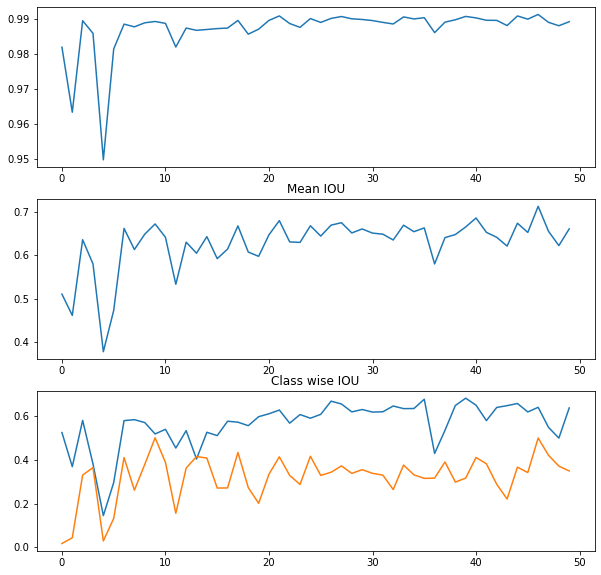

Mean IU 0.7127921204361014 47
Class wise IU [0.99522935 0.68384204 0.5022805 ]
Class wise IU best epoch [47 40 10]
Best epoch:  47


In [3]:
model_path = 'resnet50_segnet_2021-10-15_001442.907346'
model_name = 'resnet50_segnet'
max_epochs = 50
checkpoints_path = 'logs\\' + model_path + '\\checkpoints\\' + model_name

best_epoch = find_best_model(checkpoints_path, max_epochs);
print('Best epoch: ', best_epoch)

loaded weights  logs\resnet50_segnet_2021-10-15_001442.907346\checkpoints\resnet50_segnet.00047


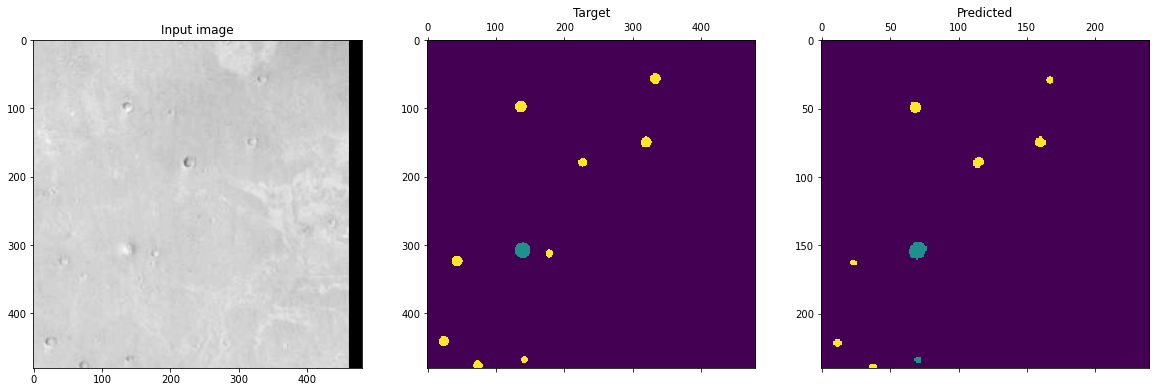

Output  0:    57222   99.344%, annotations   228588   99.214%
Output  1:      146    0.253%, annotations      414    0.180%
Output  2:      232    0.403%, annotations     1398    0.607%

Model:  resnet50_segnet
Path:   logs\resnet50_segnet_2021-10-15_001442.907346\checkpoints\resnet50_segnet
Epoch:  47

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.71279 |  0.64198 |  0.50117
Test 0.1  |  0.59035 |  0.20569 |  0.57073
Test 0.05 |  0.46837 |  0.10824 |  0.30202


In [4]:
epoch = best_epoch
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

loaded weights  logs\resnet50_segnet_2021-10-15_001442.907346\checkpoints\resnet50_segnet.00040


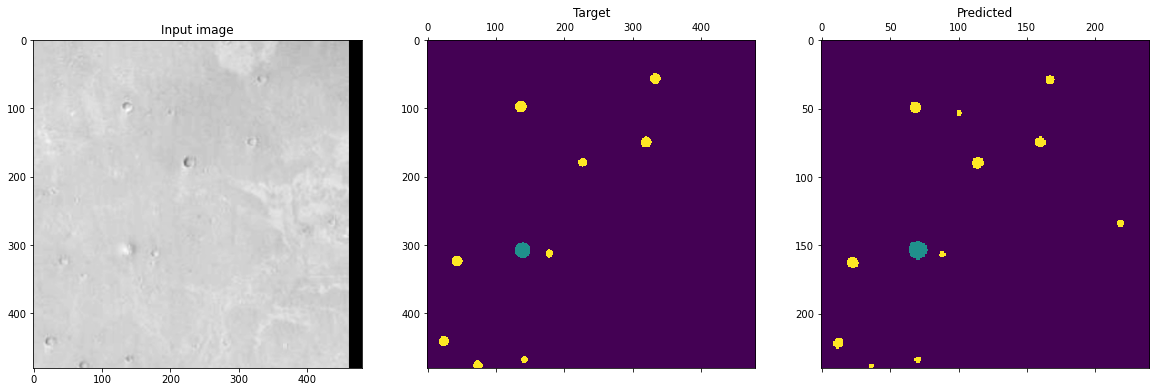

Output  0:    57082   99.101%, annotations   228588   99.214%
Output  1:      144    0.250%, annotations      414    0.180%
Output  2:      374    0.649%, annotations     1398    0.607%

Model:  resnet50_segnet
Path:   logs\resnet50_segnet_2021-10-15_001442.907346\checkpoints\resnet50_segnet
Epoch:  40

data      | mean IOU | cone IOU | crater IOU 
Val       |  0.66518 |  0.68384 |  0.31716
Test 0.1  |  0.58293 |  0.20070 |  0.55420
Test 0.05 |  0.48350 |  0.10128 |  0.35398


In [5]:
epoch = 40
model = model_from_checkpoint_path(checkpoints_path, epoch=epoch);

plot_prediction(model)

print('')
print('Model: ', model_name)
print('Path:  ', checkpoints_path)
print('Epoch: ', epoch)
evaluate(model)   

## Results summary

model | training settings | epoch | mean IOU val |val cone IOU | val crater IOU | test mean IOU | test cone IOU | test crater IOU | time 
---|---|---|---|---|---|---|---|---|---
unet_mini 30  | default   | 14 |    0.60528   |  0.39964 |  0.42292  |  0.56384 |  0.23093 |  0.46632
unet_mini 100 | default   | 27 |    0.59089   |  0.39720 |  0.38240  |  0.55890 |  0.21729 |  0.46562
unet          | default   | 25 |    0.68967   |  0.55409 |  0.52065  |  0.58019 |  0.19035 |  0.5565  
vgg_unet      | default   | 42 |  **0.71914** |  0.65150 |  0.51054  |  0.56772 |  0.21187 |  0.49759
fcn_8         | default   | 33 |    0.58874   |  0.48483 |  0.28736  |  0.52328 |  0.19243 |  0.38421
fcn_32        | default   | 50 |    0.53792   |  0.49909 |  0.12216  |  0.37279 |  0.06404 |  0.06136
fcn_8_vgg     | default   | 46 |    0.64113   |  0.50964 |  0.42001  |  0.55985 |  0.26441 |  0.42330
              | default   | 42 |    0.60138   |  0.58955 |  0.22253  |  0.52878 |  0.14595 |  0.44884
fcn_32_vgg    | default   | 40 |    0.56871   |  0.44700 |  0.26844  |  0.49023 |  0.14139 |  0.33876
pspnet        | default   | 37 |    0.49311   |  0.43340 |  0.05387  |  0.43806 |  0.12685 |  0.19588
pspnet_50     | inp       | 27 |  **0.72114** |  0.65907 |  0.50907  |  0.57276 |  0.21875 |  0.50522
pspnet_50     | default   | 40 |    0.70570   |  0.65350 |  0.46835  |  0.55565 |  0.12541 |  0.54786 
pspnet_101    | batch=2   | 50 |    0.69846   |  0.62085 |  0.47977  |  0.60088 |  0.22577 |  0.58257
segnet        | default   | 50 |    0.65372   |  0.53332 |  0.43347  |  0.57954 |  0.25655 |  0.48808
vgg_segnet    | default   | 32 |    0.65606   |  0.60215 |  0.37220  |  0.50458 |  0.16694 |  0.35467
resnet50_segnet | default | 47 |  **0.71279** |  0.64198 |  0.50117  |  0.59035 |  0.20569 |  0.57073
